# Notebook Instructions
<i>You can run the notebook document sequentially (one cell a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

# Mean Reversion Strategy on EWA and EWC

In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline

In [2]:
x = pd.read_csv('EWA.csv',index_col=0)['Adj Close']
y = pd.read_csv('EWC.csv',index_col=0)['Adj Close']

df = pd.concat([x,y],axis=1)
df.columns = ['EWA','EWC']

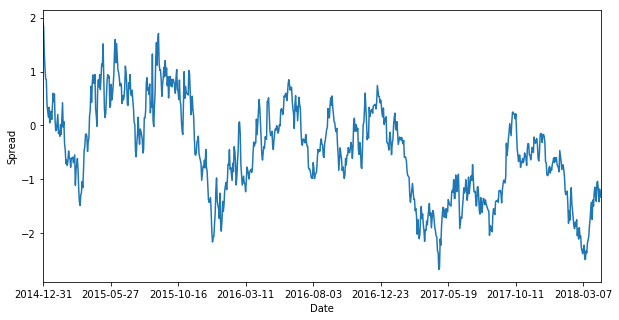

In [3]:
from statsmodels.api import OLS
model = OLS(df.EWC.iloc[:90], df.EWA.iloc[:90])
model = model.fit() 
df['spread'] = df.EWC - model.params[0] * df.EWA

# Plot the spread
df.spread.plot(figsize=(10,5))
plt.ylabel("Spread")
plt.show()

## Moving average and moving standard deviation

In [4]:
# Moving Average
df['moving_average'] = df.spread.rolling(30).mean()
# Moving Standard Deviation
df['moving_std_dev'] = df.spread.rolling(30).std()
df.head(7)

,EWA,EWC,spread,moving_average,moving_std_dev
Date,,,,,
2014-12-31,19.315804,27.184200,1.912584,NaN,NaN
2015-01-02,19.254818,27.024069,1.832243,NaN,NaN
2015-01-05,19.071854,26.298779,1.346332,NaN,NaN
2015-01-06,18.993441,25.912586,1.062730,NaN,NaN
2015-01-07,19.167692,25.940847,0.863012,NaN,NaN
2015-01-08,19.420359,26.261103,0.852693,NaN,NaN
2015-01-09,19.603321,26.035038,0.387252,NaN,NaN


## Upper band and lower band

In [5]:
df['upper_band'] = df.moving_average + 2*df.moving_std_dev
df['lower_band'] = df.moving_average - 2*df.moving_std_dev

## Long positions

In [6]:
df['long_entry'] = df.spread < df.lower_band   
df['long_exit'] = df.spread >= df.moving_average

df['positions_long'] = np.nan  
df.loc[df.long_entry,'positions_long']= 1  
df.loc[df.long_exit,'positions_long']= 0  

df.positions_long = df.positions_long.fillna(method='ffill')  

## Short positions

In [7]:
df['short_entry'] = df.spread > df.upper_band   
df['short_exit'] = df.spread <= df.moving_average

df['positions_short'] = np.nan  
df.loc[df.short_entry,'positions_short']= -1  
df.loc[df.short_exit,'positions_short']= 0  

df.positions_short = df.positions_short.fillna(method='ffill')  

## Positions

In [8]:
df['positions'] = df.positions_long + df.positions_short

## Cumulative profit and loss (PnL)

In [9]:
df['spread_difference']= df.spread - df.spread.shift(1)
df['pnl'] = df.positions.shift(1) * df.spread_difference
df['cumpnl'] = df.pnl.cumsum()

## Plot the profit and loss (PnL)

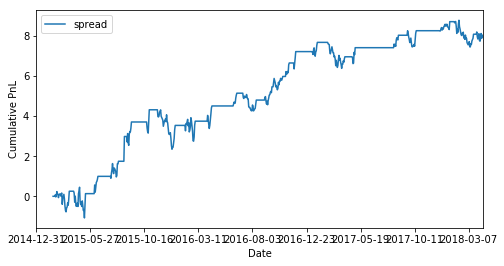

In [10]:
df.cumpnl.plot(label='spread', figsize=(8,4))  
plt.xlabel('Date')  
plt.ylabel('Cumulative PnL')  
plt.legend()  
plt.show()